In [17]:
import spotipy as sp
import spotipy.util as util

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import pickle
import numbers
import itertools


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def getTrainTestY(names):
    min_max_scaler = preprocessing.MinMaxScaler()

    trainsets = []
    testsets = []
    ytrain = []
    ytest = []
    for i, name in enumerate(names):
        dataset = pd.read_pickle("datasets/" + name)
        np_scaled = min_max_scaler.fit_transform(dataset)
        dataset = pd.DataFrame(np_scaled)
        # split up in train test
        trainsets += list(dataset[:int(0.8*len(dataset))].as_matrix())
        testsets += list(dataset[int(0.8 * len(dataset)):].as_matrix())
        # create y vector
        yvector = list(np.repeat(i, len(dataset)))
        ytrain += yvector[:int(0.8 * len(dataset))]
        ytest += yvector[int(0.8 * len(dataset)):]
    return trainsets, testsets, ytrain, ytest
names = ["classical_features", "hiphop_features", "rock_features", "house_features", "hardcore_features", "jazz_features"]
train, test, y_train, y_test = getTrainTestY(names)

In [7]:
clf = neighbors.KNeighborsClassifier(10, weights='distance')
clf.fit(train, y_train)
test_results = clf.predict(test)

In [8]:
def evaluate(labels, true_labels):
    good = 0
    wrong = 0
    for result, true_label in zip(labels, true_labels):
        if result == true_label:
            good += 1
        else:
            wrong +=1
    return good, wrong
evaluate(test_results, y_test)

(11340, 660)

Confusion matrix, without normalization


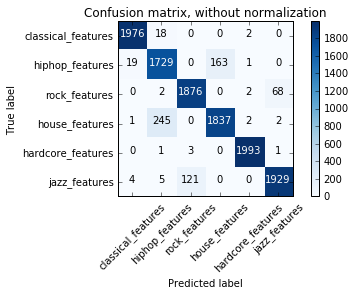

In [22]:
cnf_matrix = confusion_matrix(test_results, y_test)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=names,
                      title='Confusion matrix, without normalization')
plt.show()